In [1]:
%run ./functions_gandalf_wintermute.py
%run ./engine_gandalf_wintermute.py
%run ./Genera_LIB_V5.ipynb

5.3.1


In [2]:
def carica_storico(file_name,uct_offset,type_session,resample_tf,IS,OOS,custom_session_start,custom_session_stop,noise,pct_noise):
    import os
    import talib as ta
    
    os.chdir(dir_history)
    data = load_data_intraday_fast(file_name)  
    print("Caricato storico")
    data = data.sort_index(ascending=True)
    data.index = data.index.tz_localize('Etc/Zulu')
    data.index = data.index.tz_convert(uct_offset )
    data.index = data.index.tz_localize(None)
    data = data[data!=0]
    #data = data.fillna(method="ffill")
    data = data.iloc[1:-1]
    print("Resample dei dati")
    if type_session == 1:
        dataset=resample_custom_session("5min",resample_tf ,data,custom_session_start,custom_session_stop) 
    if type_session == 0:    
        dataset=resample_standard_session("5min",resample_tf,data)
        
    if noise == 1:
        print("AGGIUNGO RUMORE")
        dataset=add_noise(dataset.open, dataset.high, dataset.low, dataset.close,dataset.volume, pct_noise)

    dataset = dataset.loc[IS:OOS]
    dataset["dayofweek"] = dataset.index.dayofweek
    dataset["day"] = dataset.index.day
    dataset["month"] = dataset.index.month
    dataset["year"] = dataset.index.year
    dataset["dayofyear"] = dataset.index.dayofyear
    dataset["week"] = dataset.index.week
    dataset["hour"] = dataset.index.hour
    dataset["minute"] = dataset.index.minute
    dataset["daily_open"] = daily_open(dataset,1)
    dataset["daily_high"] = daily_high(dataset,1)
    dataset["daily_low"] = daily_low(dataset,1)
    dataset["daily_close"] = daily_close(dataset,1)
    dataset["AVGPRICE"]=ta.AVGPRICE(dataset.open, dataset.high, dataset.low, dataset.close)
    dataset["MEDPRICE"]=ta.MEDPRICE(dataset.high, dataset.low)
    dataset["TYPPRICE"]=ta.TYPPRICE(dataset.high, dataset.low, dataset.close)
    dataset["WCLPRICE"]=ta.WCLPRICE(dataset.high, dataset.low, dataset.close)
    history=dataset.copy()
    
    print("Carico indicatori")

    
    import legitindicators

    """data_filter=dataset.iloc[:].copy()
    for e in data_filter.columns:
        data_filter[e]= legitindicators.super_smoother(data_filter[e], 10)"""
    
    #import talib as ta
    #ATR = ta.ATR(dataset.high,dataset.low,dataset.close,5)
    #ATR = ATR.fillna(0)
    #dataATR=dataset.copy()
    #for e in dataATR.columns:
        #dataATR[e]=dataATR[e]/ATR
        
    applica_indicatori=apply_indicator(dataset)
    dataset=applica_indicatori[0]
    
   
    from sklearn.preprocessing import StandardScaler
    
    dataset_ind = dataset.iloc[:,21:].copy()


    rules=dataset.iloc[:,21:].T.values    
    rule_formulas=np.arange(len(rules))
    
    history.tail(10)
    
    history.close.plot(figsize=(20,10),title=SIMBOLO+"_"+RESAMPLE_TF)
    print("Fatto")
    return dataset , dataset_ind , history , rules, rule_formulas

In [94]:
def apply_indicator(dataset):
    dataset=dataset.copy()
    return dataset , dataset.columns


def seasonality_signal(dataframe,hour,dayofweek,day,month):
    dataset = dataframe.copy()
    dataset=dataset[dataset.index.hour.isin(hour)]
    dataset=dataset[dataset.index.dayofweek.isin(dayofweek)]
    dataset=dataset[dataset.index.day.isin(day)]
    dataset=dataset[dataset.index.month.isin(month)]
    dataset["sng"]=1
    dataframe["sng"]=dataset["sng"]
    return dataframe["sng"].fillna(0)

In [4]:
dir_home=(r"C:\Users\Drako\Genetico_V3")
dir_history=(r"C:\Users\Drako\TS_API\20230206")

In [5]:
def info_simboli():
    import os
    import numpy as np
    import pandas as pd

    valori=pd.read_csv("Markets_Specifications_Live.csv",sep=",",encoding='cp1252')
    valori.reset_index(inplace=True)
    valori.Exchange_Time=np.where(valori.Exchange_Time==-6,"CST6CDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="-5","EST5EDT",valori.Exchange_Time)
    valori.Exchange_Time=np.where(valori.Exchange_Time=="1","CET",valori.Exchange_Time)
    valori["Simbolo"]=valori.Physical
    valori=valori[(valori.Physical!="KC")&(valori.Physical!="TY")]
    return valori


os.chdir(dir_home)
valori=info_simboli()

valori

,index,SecurityName,Exchange Code,Physical,Underlying Future,MarketTypeName,Exchange,BigPointValue,Unit,Margins,Regular Open,Regular Close,Custom Open,Custom Close,Tick,Cost,AMP_simb,Exchange_Time,TT_Code,Simbolo
0,0,Australian Dollar,6A,AD,Australian Dollar,Currencies,CME,100000,0.00,2000,1700,1600,720,1400,0.000100,25,DA6,CST6CDT,6A,AD
1,1,British Pound,6B,BP,British Pound,Currencies,CME,62500,0.00,2500,1700,1600,720,1400,0.000100,25,BP6,CST6CDT,6B,BP
2,2,Crude Oil,CL,CL,Crude Oil,Energies,CME,1000,0.10,6000,1800,1700,900,1430,0.010000,50,CLE,EST5EDT,CL,CL
3,3,Euro FX,6E,EC,Euro FX,Currencies,CME,125000,0.00,3000,1700,1600,720,1400,0.000100,25,EU6,CST6CDT,6E,EC
4,4,E-mini S&P 500,ES,ES,E-mini S&P 500,Stock Indices,CME,50,0.10,12000,1700,1600,830,1515,0.250000,25,EP,CST6CDT,ES,ES
5,5,DAX Futures,FDAX,FDAX,DAX Futures,Stock Indices,EUREX,25,0.20,30000,110,2200,800,2200,0.500000,50,FDX,CET,FDAX,FDAX
6,6,EURO STOXX 50 Index,FESX,FESX,EURO STOXX 50 Index,Stock Indices,EUREX,5,0.00,3000,110,2200,800,2200,0.500000,20,DSX,CET,FESX,FESX
7,7,Euro Bund,FGBL,FGBL,Euro Bund,Fixed Income,EUREX,1000,0.00,2400,110,2200,800,2200,0.010000,20,DB,CET,FGBL,FGBL
8,8,Gold,GC,GC,Gold,Metals,CME,100,0.10,8500,1800,1700,800,1500,0.100000,60,GCE,EST5EDT,GC,GC
9,9,Copper,HG,HG,Copper,Metals,CME,25000,0.00,7500,1800,1700,800,1500,0.050000,60,CPE,EST5EDT,HG,HG


# Carico Dati e Indicatori STANDARD

Caricato storico
Resample dei dati
Carico indicatori
Fatto


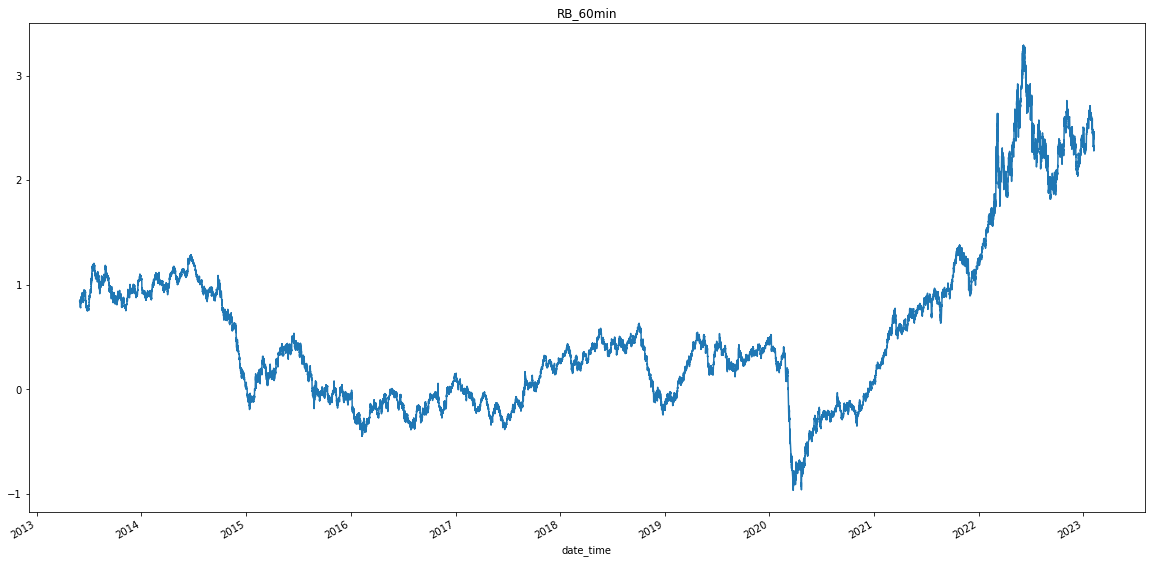

In [209]:

SIMBOLO = "RB"

TYPE_SESSION = 0    
RESAMPLE_TF = "60min"  ### RESAMPLE POSSIBILI "5min","15min","30min","60min","120min","240min","480min","1380min","1440min"]
START_DATE = "2010-01-01"
END_DATE = "2023-05-01"


dataset , dataset_ind , history , rules, rule_formulas , bigpointvalue , tick , utc_offset , custom_session_start ,\
custom_session_stop , costi = environment(SIMBOLO,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE)

In [7]:
dataset.tail()

,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,...,hour,minute,daily_open,daily_high,daily_low,daily_close,AVGPRICE,MEDPRICE,TYPPRICE,WCLPRICE
date_time,,,,,,,,,,,,,,,,,,,,,
2023-02-03 13:00:00,4165.25,4166.75,4140.75,4153.75,244131.0,4,3,2,2023,34,...,13,0,4147.25,4208.5,4142.75,4170.0,4156.6250,4153.750,4153.750000,4153.7500
2023-02-03 14:00:00,4154.00,4156.50,4139.50,4142.50,191223.0,4,3,2,2023,34,...,14,0,4147.25,4208.5,4142.75,4170.0,4148.1250,4148.000,4146.166667,4145.2500
2023-02-03 15:00:00,4142.50,4154.50,4135.00,4147.75,295699.0,4,3,2,2023,34,...,15,0,4147.25,4208.5,4142.75,4170.0,4144.9375,4144.750,4145.750000,4146.2500
2023-02-03 16:00:00,4147.75,4148.00,4143.00,4146.00,63654.0,4,3,2,2023,34,...,16,0,4147.25,4208.5,4142.75,4170.0,4146.1875,4145.500,4145.666667,4145.7500
2023-02-05 18:00:00,4134.25,4142.50,4130.25,4142.00,19760.0,6,5,2,2023,36,...,18,0,4170.00,4194.0,4132.50,4146.0,4137.2500,4136.375,4138.250000,4139.1875


In [210]:
from tqdm.notebook import tqdm

exit = 72
min_avg_trade_pct = 0.01
min_avg_trade_mon = 1000
pct_mon = 1 #0 pct / 1 monetario


results=pd.DataFrame()
data=dataset.copy()
for e in tqdm(range(len(data)-exit)):
    x=data.iloc[e:e+exit]
    if pct_mon == 0:
        tr=x.open.pct_change(-(exit-1)).dropna().values[0]
    else:
        tr=(x.close.iloc[-1]-x.open.iloc[0])*bigpointvalue
    tr=(x.close.iloc[-1]-x.open.iloc[0])*bigpointvalue
    y=x[["hour","dayofweek","day","month"]]
    y=y.iloc[0]
    y["tr"]=tr
    y=y.to_frame().T
    results=pd.concat([results,y])
 
if pct_mon == 0:
    long=results[(results.tr>0)&(results.tr>=min_avg_trade_pct)]
    print(len(long))
    short=results[(results.tr<0)&(results.tr<=-min_avg_trade_pct)]
    print(len(short))
else:
    long=results[(results.tr>0)&(results.tr>=min_avg_trade_mon)]
    print(len(long))
    short=results[(results.tr<0)&(results.tr<=-min_avg_trade_mon)]
    print(len(short))

  0%|          | 0/55589 [00:00<?, ?it/s]

21171
18948


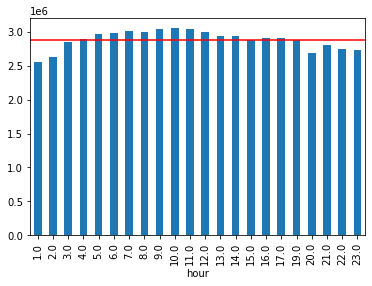

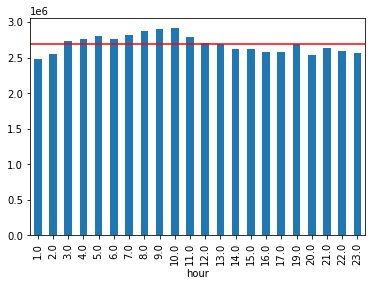

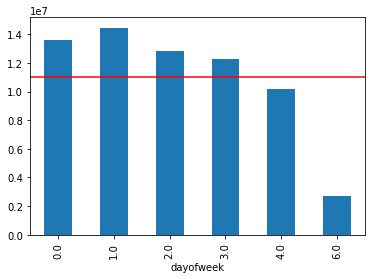

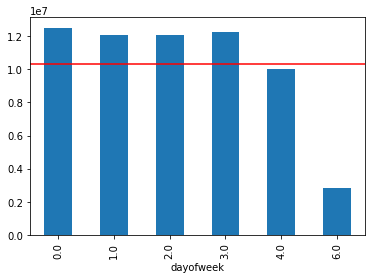

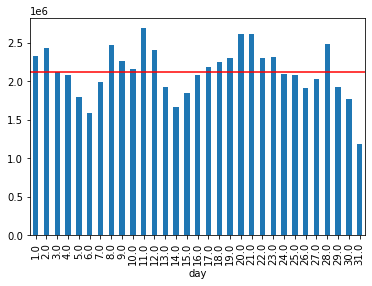

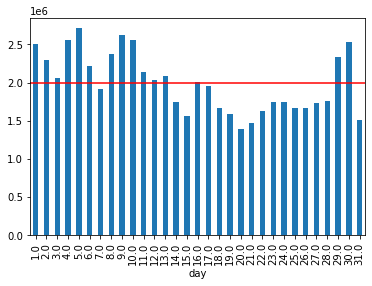

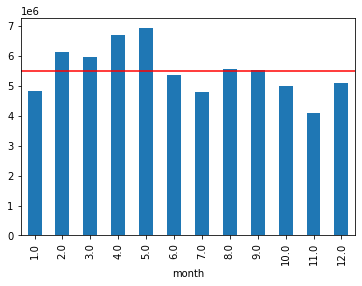

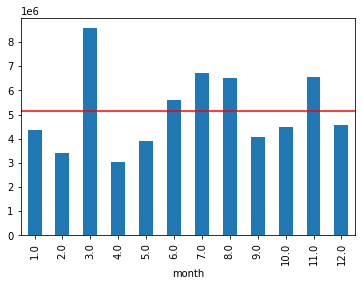

In [211]:
hour_long=long.groupby("hour").tr.sum()
hour_long=hour_long.iloc[1:]
h_mean=hour_long.mean()
plt.axhline(y=h_mean, color='r', linestyle='-')
hour_long.plot.bar()
plt.show()
hour_long=hour_long[hour_long>=h_mean].index.values
hour_long=hour_long-1

hour_short=short.groupby("hour").tr.sum()
hour_short=hour_short.iloc[1:]*(-1)
h_mean=hour_short.mean()
plt.axhline(y=h_mean, color='r', linestyle='-')
hour_short.plot.bar()
plt.show()
hour_short=hour_short[hour_short>=h_mean].index.values
hour_short=hour_short-1

dayofweek_long=long.groupby("dayofweek").tr.sum()
dayofweek_long_mean=dayofweek_long.mean()
plt.axhline(y=dayofweek_long_mean, color='r', linestyle='-')
dayofweek_long.plot.bar()
plt.show()
dayofweek_long=dayofweek_long[dayofweek_long>=dayofweek_long_mean].index.values

dayofweek_short=short.groupby("dayofweek").tr.sum()*(-1)
dayofweek_short_mean=dayofweek_short.mean()
plt.axhline(y=dayofweek_short_mean, color='r', linestyle='-')
dayofweek_short.plot.bar()
plt.show()
dayofweek_short=dayofweek_short[dayofweek_short>=dayofweek_short_mean].index.values

day_long=long.groupby("day").tr.sum()
day_long_mean=day_long.mean()
plt.axhline(y=day_long_mean, color='r', linestyle='-')
day_long.plot.bar()
plt.show()
day_long=day_long[day_long>=day_long_mean].index.values

day_short=short.groupby("day").tr.sum()*(-1)
day_short_mean=day_short.mean()
plt.axhline(y=day_short_mean, color='r', linestyle='-')
day_short.plot.bar()
plt.show()
day_short=day_short[day_short>=day_short_mean].index.values

month_long=long.groupby("month").tr.sum()
month_long_mean=month_long.mean()
plt.axhline(y=month_long_mean, color='r', linestyle='-')
month_long.plot.bar()
plt.show()
month_long=month_long[month_long>=month_long_mean].index.values

month_short=short.groupby("month").tr.sum()*(-1)
month_short_mean=month_short.mean()
plt.axhline(y=month_short_mean, color='r', linestyle='-')
month_short.plot.bar()
plt.show()
month_short=month_short[month_short>=month_short_mean].index.values

In [212]:
dataset["sng_long"] = seasonality_signal(dataset,hour_long,dayofweek_long,day_long,month_long) 

In [213]:
dataset["sng_short"] = seasonality_signal(dataset,hour_short,dayofweek_short,day_short,month_short) 

In [214]:
NAME = "Tester"

WRITELOG = False

EXIT_ON_ENTRY_BAR = True
CONSECUTIVE_TRADES = True

COSTS_FIXED = costi/2
# 10 for 10 $ for each transaction (2 * fee each operation)
COSTS_VARIABLE = 0.0
# 1.0 for 1% (2 * fee each operation)
COSTS_PERSHARES = 0.0 
# 0.01 for 1 cent for each shares traded (2 * fee each operation)

INSTRUMENT = 2 # 1: equity, 2: future, 3: crypto/forex
TICK = 0.01
BIGPOINTVALUE = bigpointvalue
ORDER_TYPE = "market"
MAX_INTRADAY_OPERATIONS = 100

QUANTITY = 1
MARGIN_PERCENT = 10 # margin to use in capital calculation

TIME_EXIT = exit  # 0 to disable
TIME_EXIT_LOSS = 0  # 0 to disable
TIME_EXIT_GAIN = 0  # 0 to disable

MONEY_STOPLOSS = 0  # 0 to disable
MONEY_TARGET = 0  # 0 to disable

MIN_MONEY_PERCENT_STOPLOSS = 0
PERCENT_STOPLOSS = 0.0  # 0 to disable

MIN_MONEY_PERCENT_TARGET = 0
PERCENT_TARGET = 0.0  # 0 to disable

enter_level = dataset.high

exit_rules_loss = False

exit_rules_gain = False 

target_level = 0 # 0 to disable

stop_level = 0 # 0 to disable

DIRECTION = "long"
enter_rules = dataset.sng_long==1
exit_rules = False

tradelist_l, open_equity_l, closed_equity_l, operation_equity_l = apply_trading_system(dataset.iloc[:], INSTRUMENT, QUANTITY, MARGIN_PERCENT, BIGPOINTVALUE, TICK, DIRECTION,
                                                                               COSTS_FIXED, COSTS_VARIABLE, COSTS_PERSHARES, 
                                                                               ORDER_TYPE, enter_level, enter_rules, MAX_INTRADAY_OPERATIONS, 
                                                                               exit_rules, exit_rules_loss, exit_rules_gain,
                                                                               target_level, stop_level,
                                                                               TIME_EXIT, TIME_EXIT_LOSS, TIME_EXIT_GAIN, 
                                                                               MONEY_STOPLOSS, MONEY_TARGET, 
                                                                               PERCENT_STOPLOSS, MIN_MONEY_PERCENT_STOPLOSS, 
                                                                               PERCENT_TARGET, MIN_MONEY_PERCENT_TARGET, WRITELOG, EXIT_ON_ENTRY_BAR, CONSECUTIVE_TRADES)


DIRECTION = "short"
enter_rules = dataset.sng_short==1
exit_rules = False

tradelist_s, open_equity_s, closed_equity_s, operation_equity_s = apply_trading_system(dataset.iloc[:], INSTRUMENT, QUANTITY, MARGIN_PERCENT, BIGPOINTVALUE, TICK, DIRECTION,
                                                                               COSTS_FIXED, COSTS_VARIABLE, COSTS_PERSHARES, 
                                                                               ORDER_TYPE, enter_level, enter_rules, MAX_INTRADAY_OPERATIONS, 
                                                                               exit_rules, exit_rules_loss, exit_rules_gain,
                                                                               target_level, stop_level,
                                                                               TIME_EXIT, TIME_EXIT_LOSS, TIME_EXIT_GAIN, 
                                                                               MONEY_STOPLOSS, MONEY_TARGET, 
                                                                               PERCENT_STOPLOSS, MIN_MONEY_PERCENT_STOPLOSS, 
                                                                               PERCENT_TARGET, MIN_MONEY_PERCENT_TARGET, WRITELOG, EXIT_ON_ENTRY_BAR, CONSECUTIVE_TRADES)

# True: Interactive, False: Static
#performance_report(data, tradelist_s, closed_equity_s, open_equity_s, 100000, 0, MARGIN_PERCENT, False)


Elaboration starting at: 2023-03-01 18:04:16.329629
Elaboration completed at: 2023-03-01 18:04:16.345642 in 0:00:00.016013

Consistency check: entries: 241 exits: 241


Elaboration starting at: 2023-03-01 18:04:16.353649
Elaboration completed at: 2023-03-01 18:04:16.370663 in 0:00:00.017014

Consistency check: entries: 194 exits: 194



<AxesSubplot:>

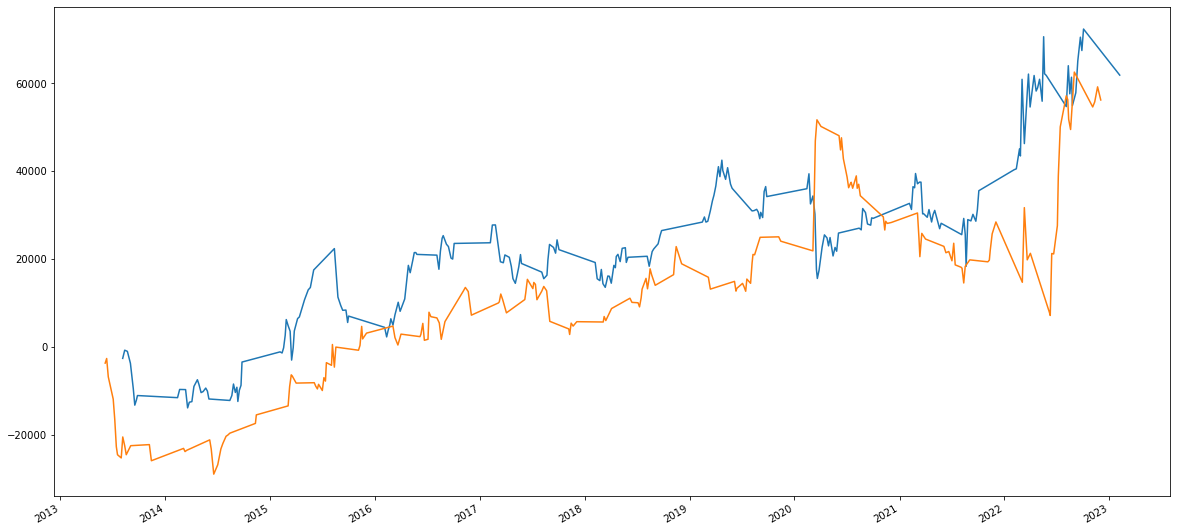

In [215]:
tradelist_l.operations.cumsum().plot(figsize=(20,10))
tradelist_s.operations.cumsum().plot(figsize=(20,10))

In [216]:
ptf=pd.concat([tradelist_l.operations,tradelist_s.operations],axis=1).fillna(0)

<AxesSubplot:>

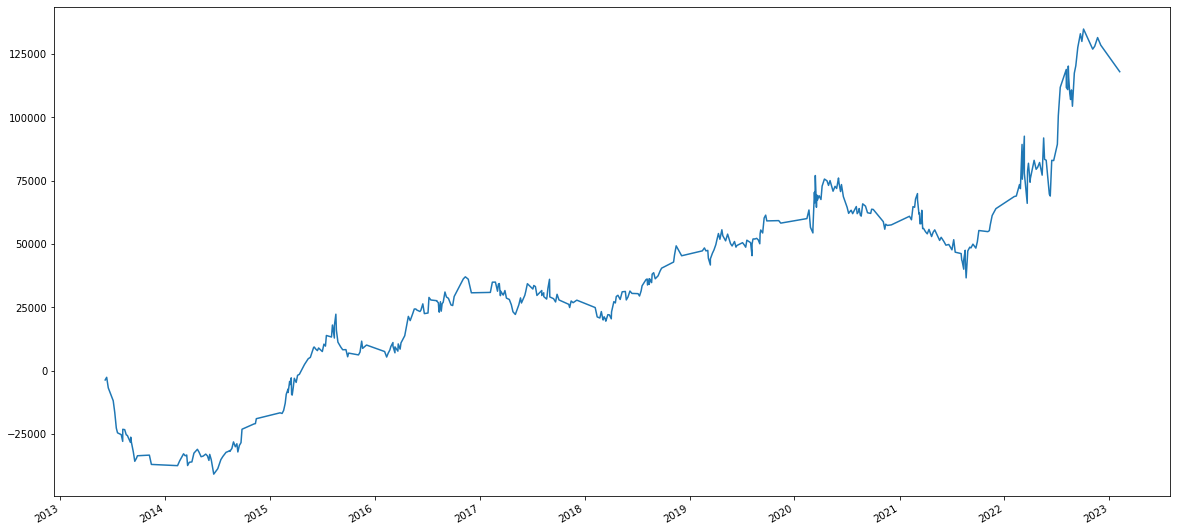

In [217]:
ptf.sum(axis=1).cumsum().plot(figsize=(20,10))

In [66]:
setup_long=[list(hour_long),list(dayofweek_long),list(day_long),list(month_long)]
setup_short=[list(hour_short),list(dayofweek_short),list(day_short),list(month_short)]
string_rule = "seasonality_signal(dataframe,hour,dayofweek,day,month)"
level = "history.close.shift(1)"

info=pd.DataFrame()
long_info=pd.DataFrame([bigpointvalue,tick,SIMBOLO,utc_offset,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE,str(custom_session_start),str(custom_session_stop),costi,"long","market",string_rule,exit,level,setup_long,0,0]).T  
short_info=pd.DataFrame([bigpointvalue,tick,SIMBOLO,utc_offset,TYPE_SESSION,RESAMPLE_TF,START_DATE,END_DATE,str(custom_session_start),str(custom_session_stop),costi,"short","market",string_rule,exit,level,setup_short,0,0]).T 
info=pd.concat([long_info,short_info])
info.columns=(["bigpointvalue","tick","file_name","uct_offset","type_session","resample_tf","start_date","end_date","custom_session_start","custom_session_stop","costi","direzione","tipo_ordine","entry_rules","exit_bars","level","ADD_RULE_CONDITION","TP","SL"])
csv_export=info
csv_export




,bigpointvalue,tick,file_name,uct_offset,type_session,resample_tf,start_date,end_date,custom_session_start,custom_session_stop,costi,direzione,tipo_ordine,entry_rules,exit_bars,level,ADD_RULE_CONDITION,TP,SL
0,50,0.25,ES,CST6CDT,0,60min,2010-01-01,2023-05-01,0830,1515,25,long,market,"seasonality_signal(dataframe,hour,dayofweek,da...",24,history.close.shift(1),"[[0.0, 1.0, 7.0, 8.0, 9.0, 10.0, 13.0, 14.0, 1...",0,0
0,50,0.25,ES,CST6CDT,0,60min,2010-01-01,2023-05-01,0830,1515,25,short,market,"seasonality_signal(dataframe,hour,dayofweek,da...",24,history.close.shift(1),"[[1.0, 6.0, 7.0, 8.0, 9.0, 14.0, 17.0, 18.0, 2...",0,0


In [67]:
import os               
os.chdir(r"C:\Users\Drako\Genetico_V3\Strategie_LS")

import uuid

idz = uuid.uuid1()
save_as = SIMBOLO+"_system_"+RESAMPLE_TF+"_"+str(idz)+".csv"
csv_export.to_csv(save_as)